In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'relative'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6797385718348965 	 Validation loss: 0.6771431444054943 	 
  1%|          | 574/57400 [00:06<09:01, 105.00it/s]
Epoch 2 	 Training loss: 0.6619802144346337 	 Validation loss: 0.6566655342861757 	 
  2%|▏         | 1148/57400 [00:12<08:41, 107.77it/s]
Epoch 3 	 Training loss: 0.6495460038193427 	 Validation loss: 0.6491682812318964 	 
  3%|▎         | 1722/57400 [00:18<08:34, 108.13it/s]
Epoch 4 	 Training loss: 0.6417912603047666 	 Validation loss: 0.642020914514186 	 
  4%|▍         | 2296/57400 [00:23<08:16, 110.95it/s]
Epoch 5 	 Training loss: 0.6349868951981906 	 Validation loss: 0.6366549023127152 	 
  5%|▌         | 2870/57400 [00:29<08:24, 108.11it/s]
Epoch 6 	 Training loss: 0.6277803546044884 	 Validation loss: 0.631163328380908 	 
  6%|▌         | 3444/57400 [00:35<08:03, 111.54it/s]
Epoch 7 	 Training loss: 0.620927786785551 	 Validation loss: 0.624577545513541 	 
  7%|▋         | 4018/57400 [00:40<08:03, 110.32it/s]
Epoch 8 	 Training loss: 0.61355

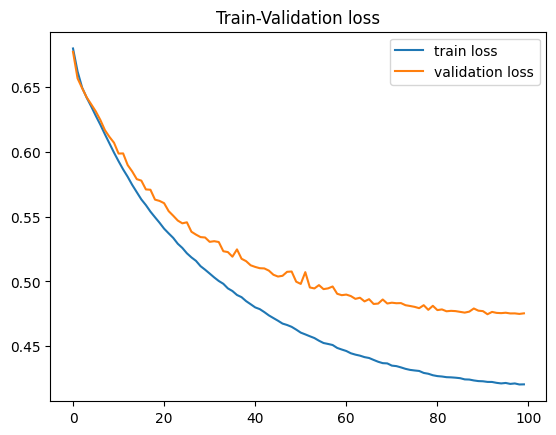

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6989795918367347, 'precision': 0.6989795918367347, 'f1': 0.6989795918367347, 'accuracy': 0.6989795918367347}
MALE {'recall': 0.7942708333333334, 'precision': 0.7942708333333334, 'f1': 0.7942708333333333, 'accuracy': 0.7942708333333334}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5555555555555556, 'precision': 0.5555555555555556, 'f1': 0.5555555555555556, 'accuracy': 0.5555555555555556}
MALE {'recall': 0.635036496350365, 'precision': 0.635036496350365, 'f1': 0.635036496350365, 'accuracy': 0.635036496350365}
FEMALE {'recall': 0.46981627296587924, 'precision': 0.46981627296587924, 'f1': 0.46981627296587924, 'accuracy': 0.46981627296587924} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5788787483702738, 'precision': 0.5788787483702738, 'f1': 0.5788787483702738, 'accuracy': 0.5788787483702738}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6797660564296337 	 Validation loss: 0.6767110612432835 	 
  1%|          | 574/57400 [00:05<08:49, 107.30it/s]
Epoch 2 	 Training loss: 0.6634974601169081 	 Validation loss: 0.6557538549778825 	 
  2%|▏         | 1148/57400 [00:11<08:37, 108.65it/s]
Epoch 3 	 Training loss: 0.6532639010650355 	 Validation loss: 0.6511460764933441 	 
  3%|▎         | 1722/57400 [00:17<08:39, 107.17it/s]
Epoch 4 	 Training loss: 0.6468635141226473 	 Validation loss: 0.6450468645257464 	 
  4%|▍         | 2296/57400 [00:22<08:36, 106.77it/s]
Epoch 5 	 Training loss: 0.640023398897789 	 Validation loss: 0.6402517466221825 	 
  5%|▌         | 2870/57400 [00:28<08:19, 109.13it/s]
Epoch 6 	 Training loss: 0.6332020555016056 	 Validation loss: 0.6356518248380241 	 
  6%|▌         | 3444/57400 [00:34<08:15, 108.95it/s]
Epoch 7 	 Training loss: 0.6264924552382493 	 Validation loss: 0.6299925173743296 	 
  7%|▋         | 4018/57400 [00:40<08:18, 107.16it/s]
Epoch 8 	 Training loss: 0.61

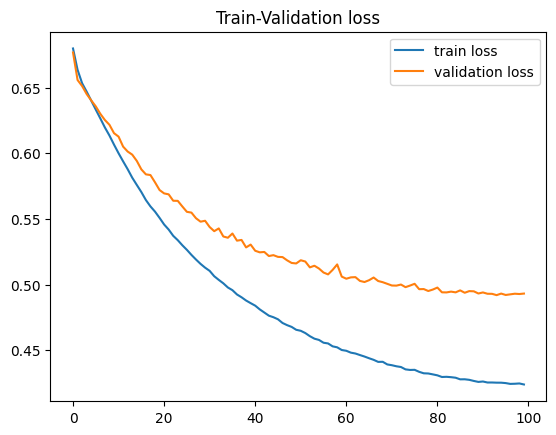

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7206632653061225, 'precision': 0.7206632653061225, 'f1': 0.7206632653061225, 'accuracy': 0.7206632653061225}
MALE {'recall': 0.7682291666666666, 'precision': 0.7682291666666666, 'f1': 0.7682291666666666, 'accuracy': 0.7682291666666666}
FEMALE {'recall': 0.675, 'precision': 0.675, 'f1': 0.675, 'accuracy': 0.675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5669191919191919, 'precision': 0.5669191919191919, 'f1': 0.5669191919191919, 'accuracy': 0.5669191919191919}
MALE {'recall': 0.6131386861313869, 'precision': 0.6131386861313869, 'f1': 0.6131386861313869, 'accuracy': 0.6131386861313869}
FEMALE {'recall': 0.5170603674540682, 'precision': 0.5170603674540682, 'f1': 0.5170603674540682, 'accuracy': 0.5170603674540682} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5958279009126467, 'precision': 0.5958279009126467, 'f1': 0.5958279009126467, 'accuracy': 0.5958279009126467}
MALE {'recall': 0.63

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6805953044924586 	 Validation loss: 0.6801060640205772 	 
  1%|          | 574/57400 [00:05<08:37, 109.74it/s]
Epoch 2 	 Training loss: 0.667266269801801 	 Validation loss: 0.6599752670627529 	 
  2%|▏         | 1148/57400 [00:11<08:47, 106.62it/s]
Epoch 3 	 Training loss: 0.6555509333618842 	 Validation loss: 0.6534012404538817 	 
  3%|▎         | 1722/57400 [00:17<08:43, 106.27it/s]
Epoch 4 	 Training loss: 0.6501069455196633 	 Validation loss: 0.651325258158021 	 
  4%|▍         | 2296/57400 [00:22<08:35, 106.84it/s]
Epoch 5 	 Training loss: 0.6443500033862084 	 Validation loss: 0.6473212969505181 	 
  5%|▌         | 2870/57400 [00:28<08:23, 108.19it/s]
Epoch 6 	 Training loss: 0.6382409748507709 	 Validation loss: 0.6393016485844628 	 
  6%|▌         | 3444/57400 [00:34<08:18, 108.27it/s]
Epoch 7 	 Training loss: 0.63227770189375 	 Validation loss: 0.6339889764785767 	 
  7%|▋         | 4018/57400 [00:40<08:20, 106.70it/s]
Epoch 8 	 Training loss: 0.62563

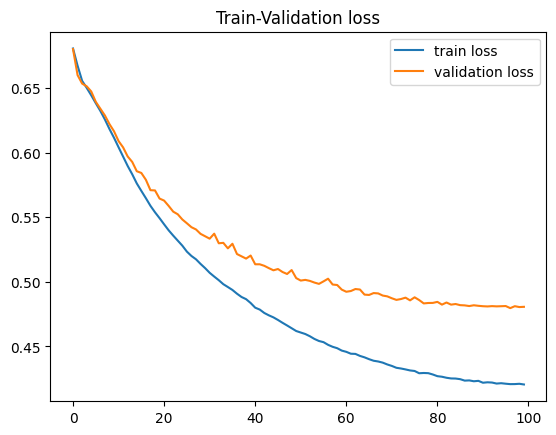

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7257653061224489, 'precision': 0.7257653061224489, 'f1': 0.725765306122449, 'accuracy': 0.7257653061224489}
MALE {'recall': 0.8151041666666666, 'precision': 0.8151041666666666, 'f1': 0.8151041666666666, 'accuracy': 0.8151041666666666}
FEMALE {'recall': 0.64, 'precision': 0.64, 'f1': 0.64, 'accuracy': 0.64} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}
MALE {'recall': 0.656934306569343, 'precision': 0.656934306569343, 'f1': 0.656934306569343, 'accuracy': 0.656934306569343}
FEMALE {'recall': 0.4540682414698163, 'precision': 0.4540682414698163, 'f1': 0.4540682414698162, 'accuracy': 0.4540682414698163} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.590612777053455, 'precision': 0.590612777053455, 'f1': 0.590612777053455, 'accuracy': 0.590612777053455}
MALE {'recall': 0.661616161616161

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7151360544217688, 'precision': 0.7151360544217688, 'f1': 0.7151360544217688, 'accuracy': 0.7151360544217688}
Métricas etiqueta male: {'recall': 0.7925347222222222, 'precision': 0.7925347222222222, 'f1': 0.7925347222222222, 'accuracy': 0.7925347222222222}
Métricas etiqueta female:  {'recall': 0.6408333333333334, 'precision': 0.6408333333333334, 'f1': 0.6408333333333334, 'accuracy': 0.6408333333333334}

 to
Resultado global: {'recall': 0.5606060606060607, 'precision': 0.5606060606060607, 'f1': 0.5606060606060607, 'accuracy': 0.5606060606060607}
Métricas etiqueta male: {'recall': 0.635036496350365, 'precision': 0.635036496350365, 'f1': 0.635036496350365, 'accuracy': 0.635036496350365}
Métricas etiqueta female:  {'recall': 0.48031496062992124, 'precision': 0.48031496062992124, 'f1': 0.48031496062992124, 'accuracy': 0.48031496062992124}

 as
Resultado global: {'recall': 0.5884398087787919, 'precision': 0.5884398087787919, 'f1': 0.5

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934112575203699 	 Validation loss: 0.6940196560601056 	 
  1%|          | 574/57400 [00:05<08:26, 112.22it/s]
Epoch 2 	 Training loss: 0.6934994155936955 	 Validation loss: 0.6943237943164373 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:27, 110.80it/s]
Epoch 3 	 Training loss: 0.6933379144203372 	 Validation loss: 0.694280659748336 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:22, 110.76it/s]
Epoch 4 	 Training loss: 0.693399179480217 	 Validation loss: 0.6943498668024095 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:08, 112.72it/s]
Epoch 5 	 Training loss: 0.6933053268788169 	 Validation loss: 0.6943982829481868 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:08, 111.62it/s]
Epoch 6 	 Training loss: 0.6932505050395008 	 Validation loss: 0.6940806801036253 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:03, 111.56it/s]
Epoch 7 	 Training loss:

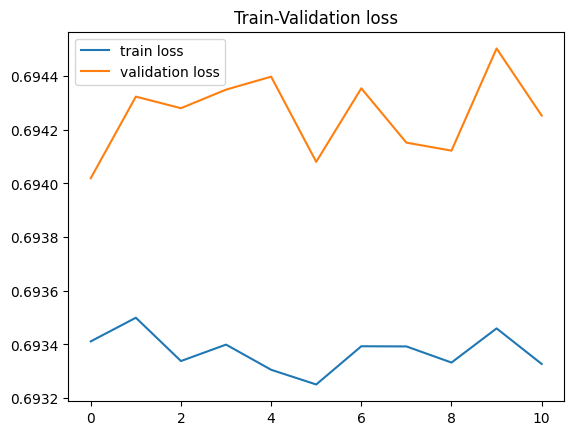

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4885204081632653, 'precision': 0.4885204081632653, 'f1': 0.4885204081632653, 'accuracy': 0.4885204081632653}
MALE {'recall': 0.9348958333333334, 'precision': 0.9348958333333334, 'f1': 0.9348958333333335, 'accuracy': 0.9348958333333334}
FEMALE {'recall': 0.06, 'precision': 0.06, 'f1': 0.06, 'accuracy': 0.06} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5176767676767676, 'precision': 0.5176767676767676, 'f1': 0.5176767676767676, 'accuracy': 0.5176767676767676}
MALE {'recall': 0.9537712895377128, 'precision': 0.9537712895377128, 'f1': 0.9537712895377128, 'accuracy': 0.9537712895377128}
FEMALE {'recall': 0.047244094488188976, 'precision': 0.047244094488188976, 'f1': 0.04724409448818897, 'accuracy': 0.047244094488188976} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
MALE {'recall': 0

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936396415432986 	 Validation loss: 0.6954853544800969 	 
  1%|          | 574/57400 [00:05<08:29, 111.64it/s]
Epoch 2 	 Training loss: 0.6938474697518432 	 Validation loss: 0.695274820772268 	 
  2%|▏         | 1148/57400 [00:11<08:30, 110.10it/s]
Epoch 3 	 Training loss: 0.6936125057499584 	 Validation loss: 0.6949587706792153 	 
  3%|▎         | 1722/57400 [00:17<08:31, 108.92it/s]
Epoch 4 	 Training loss: 0.6937950840187405 	 Validation loss: 0.6953322917728101 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:11, 112.16it/s]
Epoch 5 	 Training loss: 0.6938320592513068 	 Validation loss: 0.6952319529096959 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:17, 109.66it/s]
Epoch 6 	 Training loss: 0.693705707373104 	 Validation loss: 0.6950801459409423 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:34<08:07, 110.71it/s]
Epoch 7 	 Training loss: 0.6936715386470436 	 Validation loss: 0.694947101302066 	

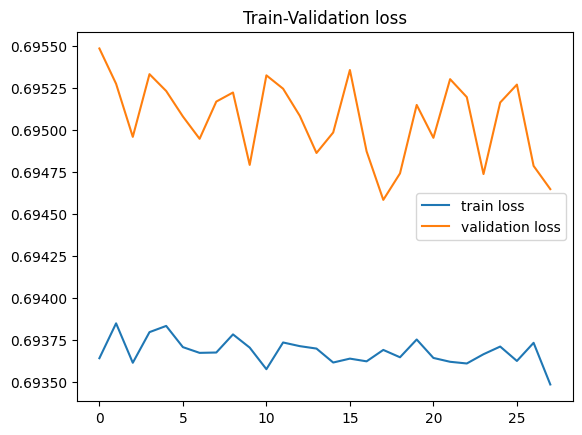

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5176010430247718, 'precision': 0.5176010430247718, 'f1': 0.5176010430247718, 'accuracy': 0.5176010430247718}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0026954177897574125, 'precision': 0.0026954177897574125, 'f1': 0.0026954177897574125, 'accuracy': 0.0026954177897574125} 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940843309259581 	 Validation loss: 0.6960615768270978 	 
  1%|          | 574/57400 [00:05<08:39, 109.37it/s]
Epoch 2 	 Training loss: 0.6939615665412531 	 Validation loss: 0.6956943414979062 	 
  2%|▏         | 1148/57400 [00:11<08:25, 111.20it/s]
Epoch 3 	 Training loss: 0.6939196249126142 	 Validation loss: 0.6958375330698692 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:22, 110.70it/s]
Epoch 4 	 Training loss: 0.6940688728663149 	 Validation loss: 0.6957371740017907 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:11, 112.15it/s]
Epoch 5 	 Training loss: 0.6940684462881255 	 Validation loss: 0.6955673098564148 	 
  5%|▌         | 2870/57400 [00:28<08:08, 111.58it/s]
Epoch 6 	 Training loss: 0.6939238324397947 	 Validation loss: 0.6958306654024933 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:34<08:06, 110.88it/s]
Epoch 7 	 Training loss: 0.6940187114041027 	 Validation loss: 0.695351872403742

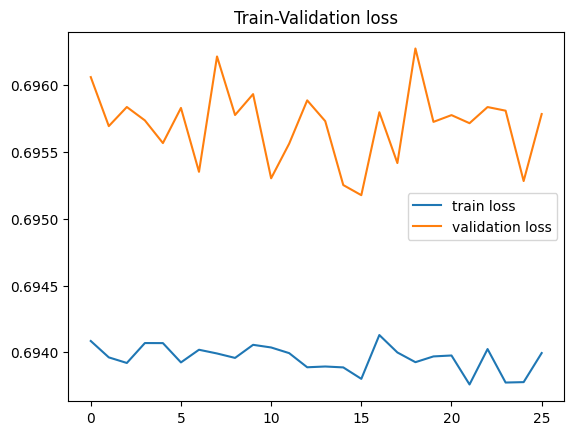

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4893707482993197, 'precision': 0.4893707482993197, 'f1': 0.4893707482993197, 'accuracy': 0.4893707482993197}
Métricas etiqueta male: {'recall': 0.9782986111111112, 'precision': 0.9782986111111112, 'f1': 0.9782986111111112, 'accuracy': 0.9782986111111112}
Métricas etiqueta female:  {'recall': 0.02, 'precision': 0.02, 'f1': 0.02, 'accuracy': 0.02}

 to
Resultado global: {'recall': 0.5185185185185185, 'precision': 0.5185185185185185, 'f1': 0.5185185185185185, 'accuracy': 0.5185185185185185}
Métricas etiqueta male: {'recall': 0.9845904298459043, 'precision': 0.9845904298459043, 'f1': 0.9845904298459043, 'accuracy': 0.9845904298459043}
Métricas etiqueta female:  {'recall': 0.015748031496062992, 'precision': 0.015748031496062992, 'f1': 0.01574803149606299, 'accuracy': 0.015748031496062992}

 as
Resultado global: {'recall': 0.5223815732290309, 'precision': 0.5223815732290309, 'f1': 0.5223815732290309, 'accuracy': 0.5223815732290309}


# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933592550638246 	 Validation loss: 0.6925252918469704 	 
  1%|          | 574/57400 [00:06<09:55, 95.49it/s]
Epoch 2 	 Training loss: 0.6933869401752326 	 Validation loss: 0.69245863769014 	 
  2%|▏         | 1148/57400 [00:12<09:49, 95.48it/s]
Epoch 3 	 Training loss: 0.6931438572730753 	 Validation loss: 0.6921133601059348 	 
  3%|▎         | 1722/57400 [00:19<09:44, 95.31it/s]
Epoch 4 	 Training loss: 0.6929860981083913 	 Validation loss: 0.6926940184528545 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:33, 96.03it/s]
Epoch 5 	 Training loss: 0.6931108755517089 	 Validation loss: 0.6931779344203108 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:26, 96.17it/s]
Epoch 6 	 Training loss: 0.693030495573004 	 Validation loss: 0.6929836980367111 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:13, 97.42it/s]
Epoch 7 	 Training loss: 0.6929505319960857 	 Validation loss: 0.6924841313038842 	 

4 e

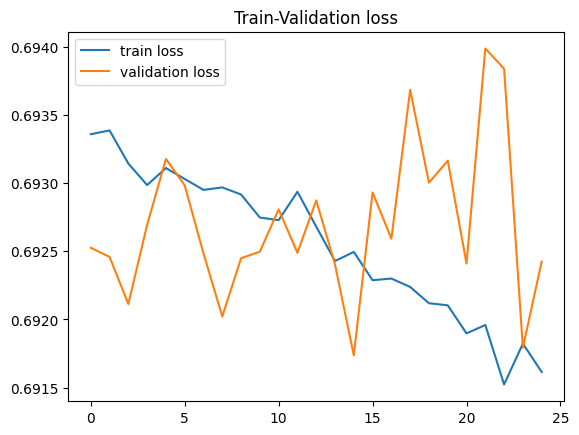

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4744897959183674, 'precision': 0.4744897959183674, 'f1': 0.4744897959183674, 'accuracy': 0.4744897959183674}
MALE {'recall': 0.2838541666666667, 'precision': 0.2838541666666667, 'f1': 0.2838541666666667, 'accuracy': 0.2838541666666667}
FEMALE {'recall': 0.6575, 'precision': 0.6575, 'f1': 0.6575, 'accuracy': 0.6575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.30900243309002434, 'precision': 0.30900243309002434, 'f1': 0.30900243309002434, 'accuracy': 0.30900243309002434}
FEMALE {'recall': 0.7165354330708661, 'precision': 0.7165354330708661, 'f1': 0.716535433070866, 'accuracy': 0.7165354330708661} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933398317376911 	 Validation loss: 0.6932060617511555 	 
  1%|          | 574/57400 [00:06<09:43, 97.45it/s]
Epoch 2 	 Training loss: 0.6932104203966852 	 Validation loss: 0.6920782499394175 	 
  2%|▏         | 1148/57400 [00:12<09:53, 94.71it/s]
Epoch 3 	 Training loss: 0.6932352537269791 	 Validation loss: 0.6926672044446913 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:30, 97.64it/s]
Epoch 4 	 Training loss: 0.6931428296640775 	 Validation loss: 0.6929729964773533 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:40, 94.87it/s]
Epoch 5 	 Training loss: 0.693052317414965 	 Validation loss: 0.692737634909355 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:43, 93.42it/s]
Epoch 6 	 Training loss: 0.6930325045818235 	 Validation loss: 0.692098440760273 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:12, 97.75it/s]
Epoch 7 	 Training loss: 0.6930292693164706 	 Validation los

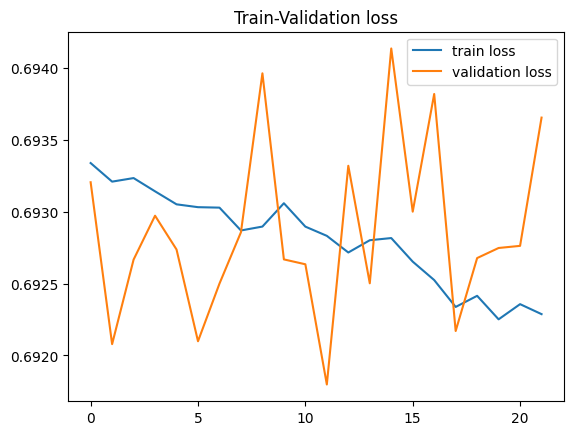

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4872448979591837, 'precision': 0.4872448979591837, 'f1': 0.4872448979591837, 'accuracy': 0.4872448979591837}
MALE {'recall': 0.11458333333333333, 'precision': 0.11458333333333333, 'f1': 0.11458333333333333, 'accuracy': 0.11458333333333333}
FEMALE {'recall': 0.845, 'precision': 0.845, 'f1': 0.845, 'accuracy': 0.845} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.0948905109489051, 'precision': 0.0948905109489051, 'f1': 0.0948905109489051, 'accuracy': 0.0948905109489051}
FEMALE {'recall': 0.8871391076115486, 'precision': 0.8871391076115486, 'f1': 0.8871391076115486, 'accuracy': 0.8871391076115486} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933334820777282 	 Validation loss: 0.6934980679366548 	 
  1%|          | 574/57400 [00:06<09:54, 95.62it/s]
Epoch 2 	 Training loss: 0.6932260714964584 	 Validation loss: 0.6933661062838667 	 
  2%|▏         | 1148/57400 [00:12<09:41, 96.76it/s]
Epoch 3 	 Training loss: 0.6931698636933902 	 Validation loss: 0.6927718732316616 	 
  3%|▎         | 1722/57400 [00:19<09:37, 96.33it/s]
Epoch 4 	 Training loss: 0.693091723769384 	 Validation loss: 0.6927066202891075 	 
  4%|▍         | 2296/57400 [00:25<09:27, 97.18it/s]
Epoch 5 	 Training loss: 0.6931010773372982 	 Validation loss: 0.6926532246298709 	 
  5%|▌         | 2870/57400 [00:31<09:26, 96.30it/s]
Epoch 6 	 Training loss: 0.6929807091839222 	 Validation loss: 0.6927881574226638 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:11, 97.92it/s]
Epoch 7 	 Training loss: 0.6929485502974082 	 Validation loss: 0.6924424070422932 	 
  7%|▋         | 4018/57400 [00:44<09:08, 97.27it/s]
Epoch 8

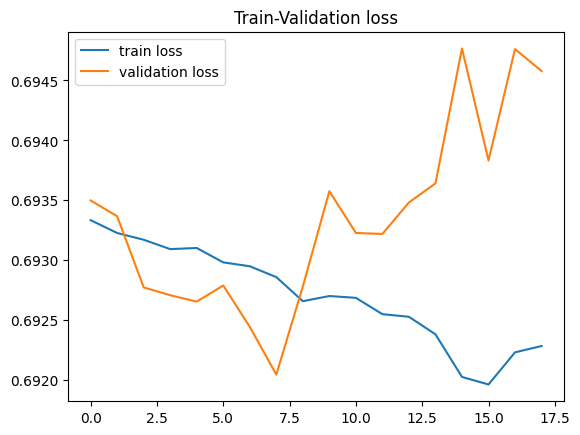

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5293367346938775, 'precision': 0.5293367346938775, 'f1': 0.5293367346938775, 'accuracy': 0.5293367346938775}
MALE {'recall': 0.18229166666666666, 'precision': 0.18229166666666666, 'f1': 0.18229166666666663, 'accuracy': 0.18229166666666666}
FEMALE {'recall': 0.8625, 'precision': 0.8625, 'f1': 0.8625, 'accuracy': 0.8625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.494949494949495, 'precision': 0.494949494949495, 'f1': 0.494949494949495, 'accuracy': 0.494949494949495}
MALE {'recall': 0.12895377128953772, 'precision': 0.12895377128953772, 'f1': 0.12895377128953772, 'accuracy': 0.12895377128953772}
FEMALE {'recall': 0.889763779527559, 'precision': 0.889763779527559, 'f1': 0.889763779527559, 'accuracy': 0.889763779527559} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recal

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49702380952380953, 'precision': 0.49702380952380953, 'f1': 0.49702380952380953, 'accuracy': 0.49702380952380953}
Métricas etiqueta male: {'recall': 0.1935763888888889, 'precision': 0.1935763888888889, 'f1': 0.1935763888888889, 'accuracy': 0.1935763888888889}
Métricas etiqueta female:  {'recall': 0.7883333333333333, 'precision': 0.7883333333333333, 'f1': 0.7883333333333333, 'accuracy': 0.7883333333333333}

 to
Resultado global: {'recall': 0.492003367003367, 'precision': 0.492003367003367, 'f1': 0.492003367003367, 'accuracy': 0.492003367003367}
Métricas etiqueta male: {'recall': 0.17761557177615572, 'precision': 0.17761557177615572, 'f1': 0.17761557177615572, 'accuracy': 0.17761557177615572}
Métricas etiqueta female:  {'recall': 0.8311461067366579, 'precision': 0.8311461067366579, 'f1': 0.8311461067366579, 'accuracy': 0.8311461067366579}

 as
Resultado global: {'recall': 0.48283355063016076, 'precision': 0.48283355063016076, 'f1